In [1]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt
import numpy as np
import tqdm

from autoencoders.mlpmodels import MLPAutoEncoder

from torchinfo import summary

In [2]:
MNISTdataset = datasets.MNIST(root="./mnist", train=True, transform=ToTensor())

We will train the MNIST dataset autoencoder by flattening the input 28x28 image into a 784 dimensional vector

In [3]:
n_hidden = 4
model = MLPAutoEncoder(n_inputs=784, n_hidden=n_hidden)

Let's print out the summary of the model

In [4]:
summary(model, [5, 1, 784])

D:\CodeProjects\autoencoders\.venv\Lib\site-packages\torch\nn\modules\instancenorm.py:115: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
MLPAutoEncoder                           [5, 1, 784]               --
├─MLPEncoder: 1-1                        [5, 1, 3]                 --
│    └─Linear: 2-1                       [5, 1, 64]                50,240
│    └─ReLU: 2-2                         [5, 1, 64]                --
│    └─InstanceNorm1d: 2-3               [5, 1, 64]                --
│    └─Linear: 2-4                       [5, 1, 3]                 195
│    └─ReLU: 2-5                         [5, 1, 3]                 --
├─MLPDecoder: 1-2                        [5, 1, 784]               --
│    └─Linear: 2-6                       [5, 1, 64]                256
│    └─ReLU: 2-7                         [5, 1, 64]                --
│    └─InstanceNorm1d: 2-8               [5, 1, 64]                --
│    └─Linear: 2-9                       [5, 1, 784]               50,960
│    └─Sigmoid: 2-10                     [5, 1, 784]               --
Total

Now let's train the auto-encoder and see how it works

# Training the model
We will train the model with the Adam optimizer using batch gradient descent. the `torch.optim.Adam` optimizer will do all the legwork in calculating the gradients and updating the network weights. We just have to build the batch aggregator and the loss function.

For the loss function, let's use a simple MSE (Mean Squared Error) loss. This loss will be used to calculate the gradient for each weight in the model and update them to minimize the loss function.

In [5]:
def loss_fn(pred: torch.tensor, target: torch.tensor) -> float:
    # we will use a simple MSE (mean-squared error) between the
    # input image and generated image to calculate the loss
    return torch.mean((pred - target) ** 2)

Epoch 1: 100%|██████████████████████████████████████████████████████| 938/938 [00:11<00:00, 82.77it/s, loss:  6.83e-02]


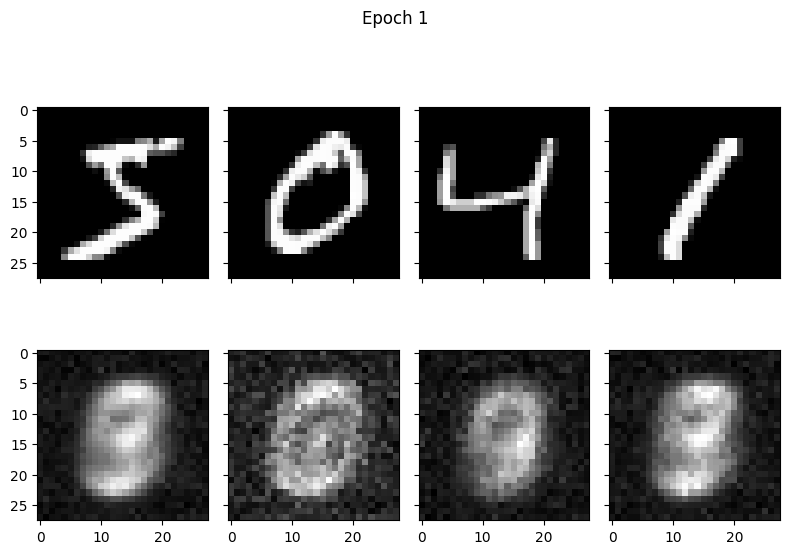

Epoch 6: 100%|██████████████████████████████████████████████████████| 938/938 [00:11<00:00, 81.11it/s, loss:  4.67e-02]


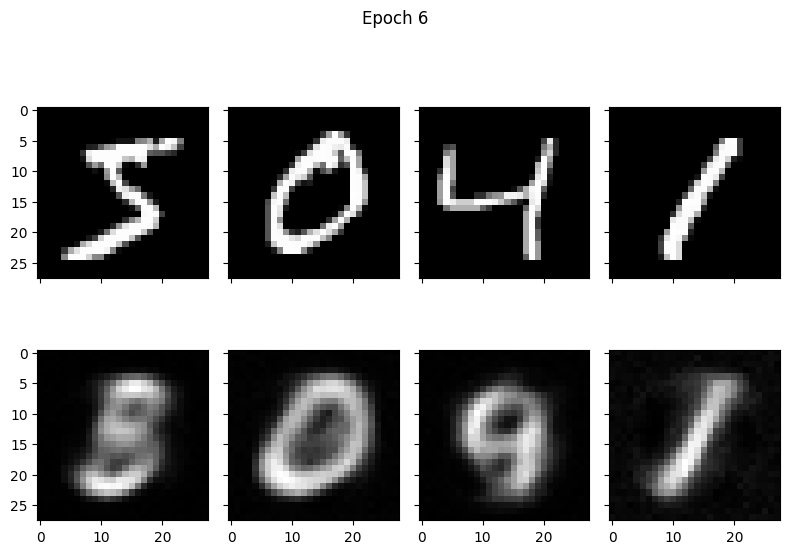

Epoch 11: 100%|█████████████████████████████████████████████████████| 938/938 [00:11<00:00, 78.35it/s, loss:  4.68e-02]


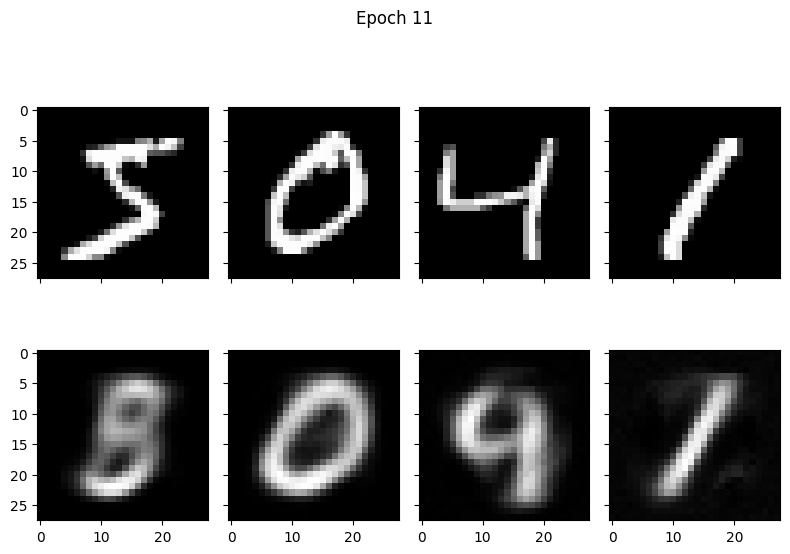

Epoch 16: 100%|█████████████████████████████████████████████████████| 938/938 [00:11<00:00, 81.20it/s, loss:  3.56e-02]


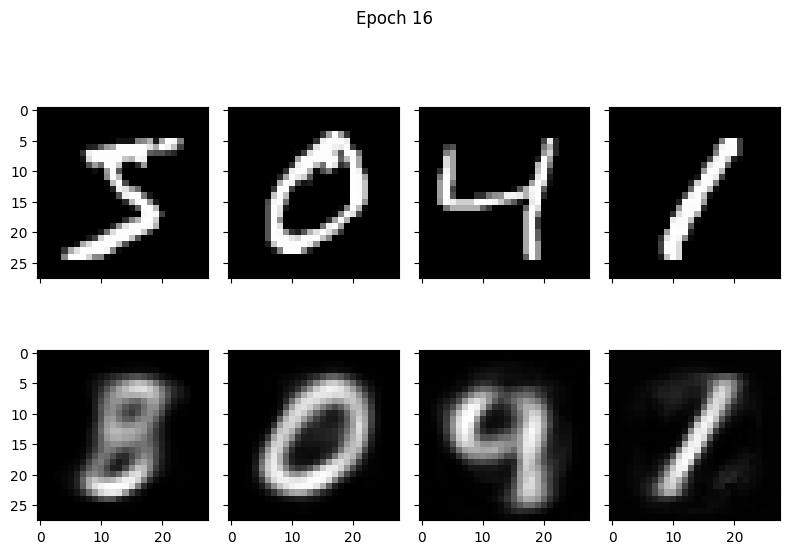

Epoch 21: 100%|█████████████████████████████████████████████████████| 938/938 [00:11<00:00, 79.47it/s, loss:  4.59e-02]


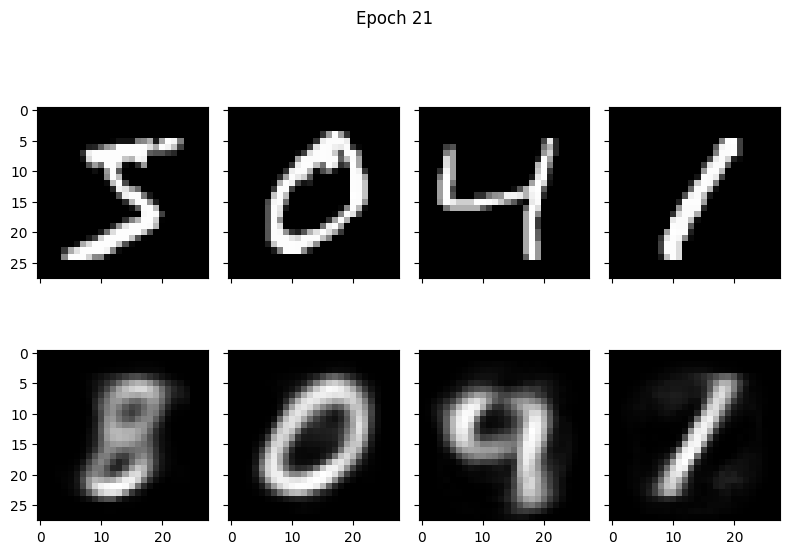

Epoch 26: 100%|█████████████████████████████████████████████████████| 938/938 [00:11<00:00, 79.29it/s, loss:  3.34e-02]


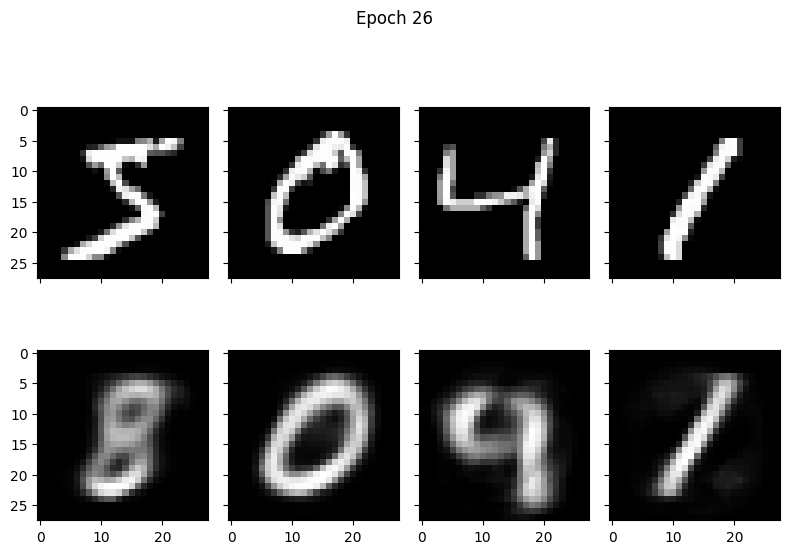

Epoch 31: 100%|█████████████████████████████████████████████████████| 938/938 [00:11<00:00, 80.68it/s, loss:  4.24e-02]


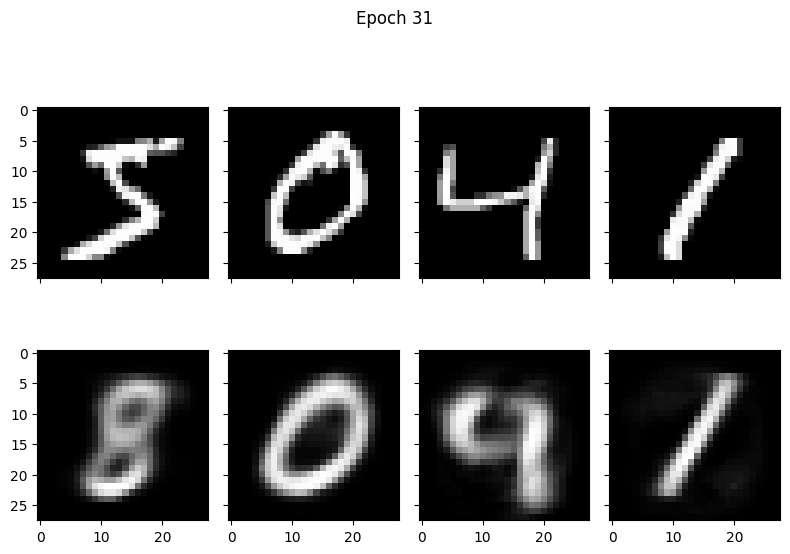

Epoch 36: 100%|█████████████████████████████████████████████████████| 938/938 [00:11<00:00, 80.47it/s, loss:  3.60e-02]


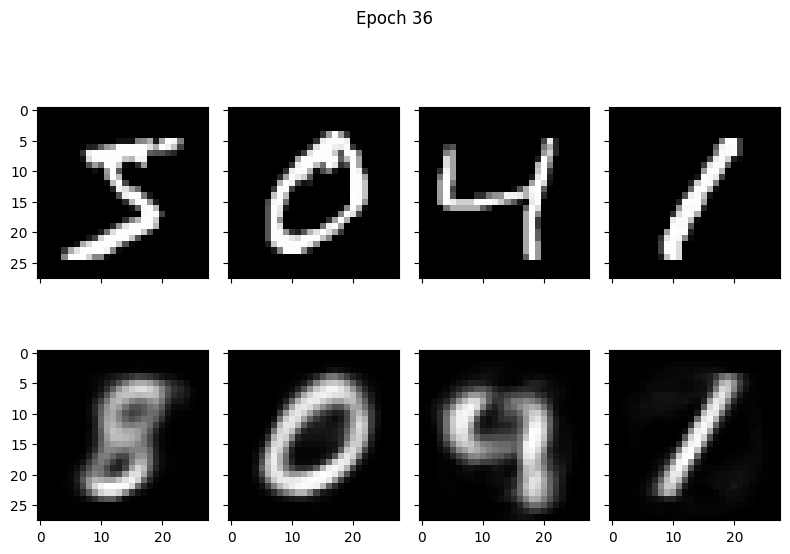

Epoch 41: 100%|█████████████████████████████████████████████████████| 938/938 [00:12<00:00, 75.05it/s, loss:  3.37e-02]


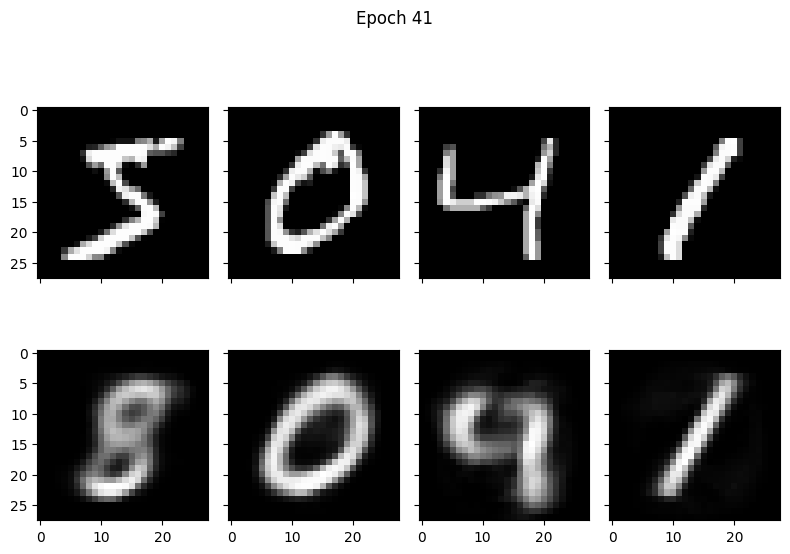

Epoch 46: 100%|█████████████████████████████████████████████████████| 938/938 [00:11<00:00, 80.09it/s, loss:  4.01e-02]


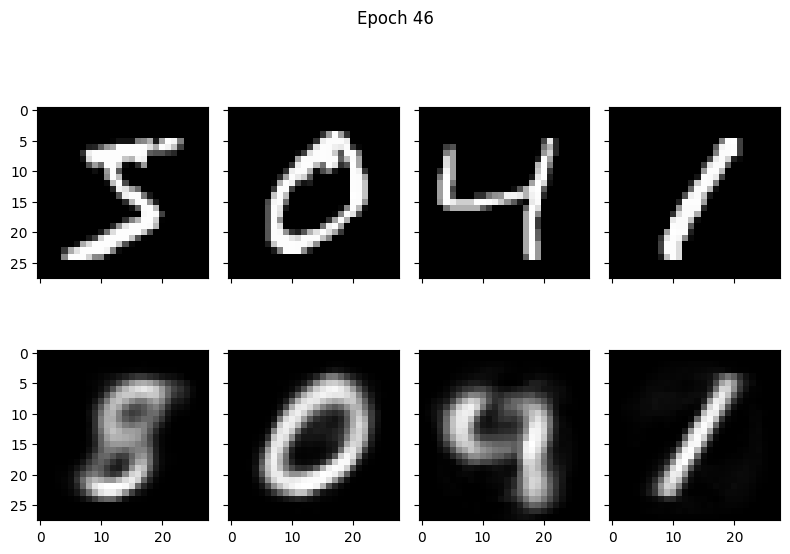

Epoch 50: 100%|█████████████████████████████████████████████████████| 938/938 [00:11<00:00, 80.25it/s, loss:  3.53e-02]


In [6]:
learning_rate = 1e-4
n_epochs = 50
optimizer = Adam(model.parameters(), lr=learning_rate)
batch_size = 64

# convert the dataset to a persistent memory data loader
# so we can batch load the data
dataloader = DataLoader(MNISTdataset, batch_size=batch_size, pin_memory=True, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# move the model to the gpu if needed
model.to(device)


for n in range(n_epochs):
    # set the model to train mode so it calculates the gradients
    model.train()
    with tqdm.tqdm(dataloader, desc=f'Epoch {n + 1}') as pbar:
        for batch in pbar:
            x = batch[0]  # we only need the image not the label
            
            # zero out the gradient from the previous loop
            optimizer.zero_grad()
            
            x = x.float().to(device)
            generated, _ = model(x.view((x.shape[0], 1, -1)))  # for now ignore the latent vector

            # calculate the new loss and the gradient
            loss = loss_fn(generated.view((x.shape[0], 1, 28, 28)), x)
            loss.backward()

            # update the weights
            optimizer.step()

            pbar.set_postfix_str(f"loss: {loss.item(): .2e}")

    # evaluate the model performance after each batch
    if n % 5 == 0:
        model.eval()
    
        # let's choose 4 images from the sample
        batch = torch.stack([MNISTdataset[i][0] for i in range(4)])
            
        with torch.no_grad():  # so we don't add this sample to the next round of gradient calculations
            batch_test = batch.float().to(device)
            generated_test, _ = model(batch_test.view((4, 1, -1)))  # for now ignore the latent vector
            generated_test = generated_test.view((4, 1, 28, 28)) # transform it back to the origin 28x28 image
        
        fig, axs = plt.subplots(2, 4, dpi=100, figsize=(8, 6), sharex=True, sharey=True)
        fig.suptitle(f'Epoch {n + 1}')
        for i in range(4):
            # if you are using CPU to train, the .cpu() might error! Remove it!
            axs[0, i].imshow(batch_test[i].cpu().numpy()[0], cmap='gray')
            axs[1, i].imshow(generated_test[i].cpu().numpy()[0], cmap='gray')
        plt.tight_layout()
        plt.show()

# Extracting the latent vectors
Let's extract the latent vectors and the labels

In [7]:
labels = np.zeros(len(MNISTdataset))

# latent vector is n x hidden, where hidden = 16 in our case
z = np.zeros((len(MNISTdataset), n_hidden))

for i, (img, label) in enumerate(tqdm.tqdm(MNISTdataset)):
    with torch.no_grad():
        z[i] = model.encoder(img.float().to(device).view((1, 1, -1))).cpu().numpy()
    labels[i] = label

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:39<00:00, 1502.21it/s]


Let's plot the raw latent space

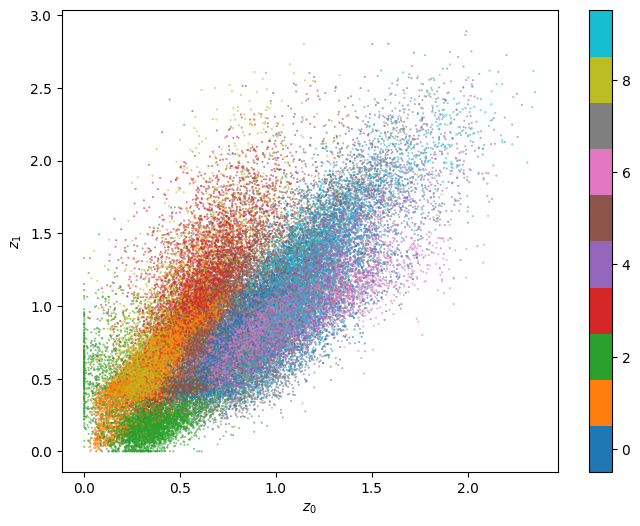

In [13]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(8, 6))

scatter = ax.scatter(z[:, 0], z[:, 1], s=0.1, c=labels, cmap='tab10', vmin=-0.5, vmax=9.5)
plt.colorbar(scatter)
ax.set_xlabel(r'$z_0$')
ax.set_ylabel(r'$z_1$')
plt.show()

This is usually very hard to see what's going on. So let's use some dimensionality reduction metric to disentangle this

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
reduced_z = pca.fit_transform(z)

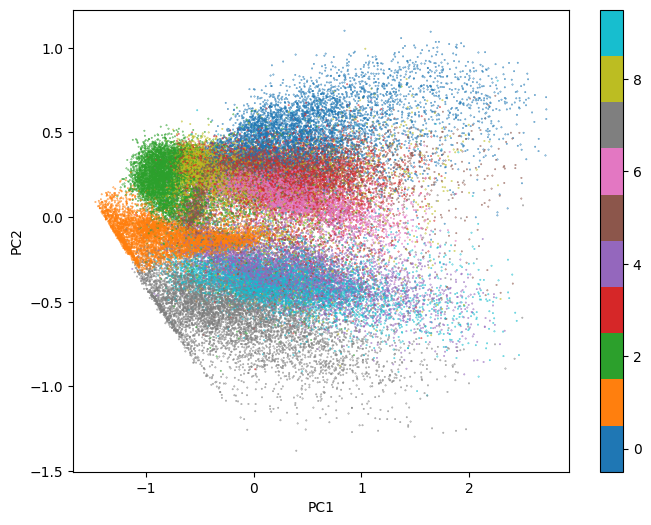

In [14]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(8, 6))

scatter = ax.scatter(reduced_z[:, 0], reduced_z[:, 1], s=0.1, c=labels, cmap='tab10', vmin=-0.5, vmax=9.5)
ax.set_xlabel(r'PC1')
ax.set_ylabel(r'PC2')
plt.colorbar(scatter)
plt.show()